# Principal Component Analysis (PCA) on factbook_prepared

The goal of Principal Component Analysis (PCA) is to reduce the **number of dimensions** of a d-dimensional dataset by projecting it onto a k-dimensional subspace (with k < d) in order to increase the **computational efficiency** while retaining most of the information.

The k dimensions that we keep (eigenvectors) are called "**principal components**".

The PCA approach requires to:

* Standardize the data.
* Obtain the Eigenvectors and Eigenvalues from a Singular Vector Decomposition (SVD).
* Choose the number k of principal components to keep.
* Construct a projection matrix with the selected k eigenvectors.
* Project original dataset to a k-dimensional feature subspace.

Choosing the number k can be done systematically by selecting the components that best describe the variance in our data. The amount of information (variance) contained by each eigenvector can be measured by the **explained variance**.

This notebook will display the explained variance for your dataset and help you choose the right amount of eigenvectors ("principal components").

* [Setup and loading the data](#setup)
* [Preprocessing of the data](#preprocessing)
* [Computation of the PCA](#pca)
* [Display of the explained variance](#explained-variance)
* [Retaining of the most significant components](#final-pca)
* [Visualizing the vectors in the original space](#original-space)
* [Applying the projection](#apply)

<center><strong>Select Cell > Run All to execute the whole analysis</strong></center>

## Setup and dataset loading <a id="setup" />

First of all, let's load the libraries that we'll use

In [1]:
import dataiku                               # Access to Dataiku datasets
import pandas as pd, numpy as np             # Data manipulation
from sklearn.decomposition import PCA        # The main algorithm
from matplotlib import pyplot as plt         # Graphing
import seaborn as sns                        # Graphing
from collections import defaultdict, Counter # Utils
sns.set(style="white")                       # Tuning the style of charts
import warnings                              # Disable some warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)
from dataiku import insights

The first thing we do is now to load the dataset and put aside the three main types of columns:

* Numerics
* Categorical
* Dates

Since analyzing PCA requires to have the data in memory, we are only going to load a sample of the data. Modify the following cell to change the size of the sample.

Also, by default, date features are not kept. Modify the following cell to change that.

In [2]:
dataset_limit = 10000
keep_dates = False

Load a DSS dataset as a Pandas dataframe

In [3]:
# Take a handle on the dataset
mydataset = dataiku.Dataset("factbook_prepared")

# Load the first lines.
# You can also load random samples, limit yourself to some columns, or only load
# data matching some filters.
#
# Please refer to the Dataiku Python API documentation for more information
df = mydataset.get_dataframe(limit = dataset_limit)

df_orig = df.copy()

# Get the column names
numerical_columns = list(df.select_dtypes(include=[np.number]).columns)
categorical_columns = list(df.select_dtypes(include=[object]).columns)
date_columns = list(df.select_dtypes(include=['<M8[ns]']).columns)

# Print a quick summary of what we just loaded
print ("Loaded dataset")
print ("   Rows: %s" % df.shape[0])
print ("   Columns: %s (%s num, %s cat, %s date)" % (df.shape[1],
                                                    len(numerical_columns), len(categorical_columns),
                                                    len(date_columns)))

Loaded dataset
   Rows: 231
   Columns: 11 (10 num, 1 cat, 0 date)


## Preprocessing of the data <a id="preprocessing" />

Keep the dates as features if requested by the user

In [4]:
columns_to_drop = []

if keep_dates:
    df[date_columns] = df[date_columns].astype(int)*1e-9
else:
    columns_to_drop.extend(date_columns)

Get rid of the columns that contain too many unique values

In [5]:
DROP_LIMIT_ABS = 200
CAT_DROP_LIMIT_RATIO = 0.5
for feature in categorical_columns:
    nu = df[feature].nunique()

    if nu > DROP_LIMIT_ABS or nu > CAT_DROP_LIMIT_RATIO*df.shape[0]:
        print ("Dropping feature %s with %s values" % (feature, nu))
        columns_to_drop.append(feature)

Dropping feature Country with 231 values


We then need to impute missing values

In [6]:
# Use mean for numerical features
for feature in numerical_columns:
    v = df[feature].mean()
    if np.isnan(v):
        v = 0
    print ("Filling %s with %s" % (feature, v))
    df[feature] = df[feature].fillna(v)

# Use mode for categorical features
for feature in categorical_columns:
    v = df[feature].value_counts().index[0]
    df[feature] = df[feature].fillna(v)

Filling Area(sq km) with 647973.8744588745
Filling Birth rate(births/1000 population) with 22.173059163059154
Filling Death rate(deaths/1000 population) with 9.464311926605502
Filling Exports with 40621055922.58065
Filling GDP with 250472862162.1622
Filling GDP - per capita with 10544.301801801801
Filling Life expectancy at birth(years) with 67.47036697247702
Filling Oil - production(bbl/day) with 367546.64943232853
Filling Oil - proved reserves(bbl) with 14169251629.803156
Filling Population with 28468116.285386883


Drop the columns

In [7]:
print ("Dropping the following columns: %s" % columns_to_drop)
df = df.drop(columns_to_drop, axis=1)

Dropping the following columns: ['Country']


For all categorical features, we are going to "dummy-encode" them (also sometimes called one-hot encoding).

Basically, a categorical feature is replaced by one column per value. Each created value contains 0 or 1 depending on whether the original value was the one of the column.

In [8]:
# For categorical variables with more than that many values, we only keep the most frequent ones
LIMIT_DUMMIES = 100

# Only keep the top 100 values
def select_dummy_values(train, features):
    dummy_values = {}
    for feature in features:
        values = [
            value
            for (value, _) in Counter(train[feature]).most_common(LIMIT_DUMMIES)
        ]
        dummy_values[feature] = values
    return dummy_values

DUMMY_VALUES = select_dummy_values(df, [x for x in categorical_columns if not x in columns_to_drop])


def dummy_encode_dataframe(df):
    for (feature, dummy_values) in DUMMY_VALUES.items():
        for dummy_value in dummy_values:
            dummy_name = u'%s_value_%s' % (feature, dummy_value.decode('utf-8'))
            df[dummy_name] = (df[feature] == dummy_value).astype(float)
        del df[feature]
        print ('Dummy-encoded feature %s' % feature)

dummy_encode_dataframe(df)

Finally, we rescale the whole data

In [9]:
X = df.values
from sklearn.preprocessing import StandardScaler
ss = StandardScaler().fit(X)
X_std = ss.transform(X)

## Computation of the PCA <a id="pca" />

Let's "fit" the PCA algorithm (in other words, let's compute the singular value decomposition)

In [10]:
sklearn_pca = PCA()
Y_sklearn = sklearn_pca.fit_transform(X_std)

Here the PCA is a full SVD (k=d, we have not yet applied any "reduction").

## Display of the explained variance of the eigenvectors. <a id="explained-variance" />

The first thing to do after fitting a PCA algorihtm is to plot the **explained variance** of each eigenvector (how much information from the original data does each vector contain).

We also compute how many of these vectors (in order) must be used to retain 90% of the variance of the original dataset (you can change that figure below)

In [11]:
VARIANCE_TO_KEEP = 0.9

Number of components to keep to retain 90.0% of the variance: 5 out of the original 10


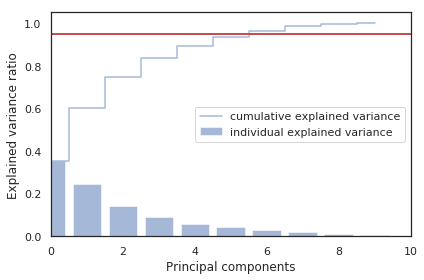

In [12]:
plt.bar(range(sklearn_pca.n_components_), sklearn_pca.explained_variance_ratio_, alpha=0.5, align='center',label='individual explained variance')
plt.step(range(sklearn_pca.n_components_), [sklearn_pca.explained_variance_ratio_[:y].sum() for y in range(1,sklearn_pca.n_components_+1)], alpha=0.5, where='mid',label='cumulative explained variance')
plt.axhline(y=0.95, linewidth=2, color = 'r')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.xlim([0, sklearn_pca.n_components_])
plt.legend(loc='best')
plt.tight_layout()

keep_recommend = [sklearn_pca.explained_variance_ratio_[:y].sum()>VARIANCE_TO_KEEP for y in range(1,sklearn_pca.n_components_+1)].count(False)
print ("Number of components to keep to retain %s%% of the variance:" % (100*VARIANCE_TO_KEEP), keep_recommend, "out of the original", sklearn_pca.n_components_)
insights.save_figure("Principal-components-explained-variance1")

## Retaining only some vectors <a id="final-pca" />

You should decide now how many components you want to keep and change the following parameter.

By default we keep the recommended value from the above figure

In [13]:
retained_components_number = keep_recommend

Let's run the PCA again but with a limited number of components this time

In [14]:
sklearn_pca_final = PCA(n_components=retained_components_number)
Y_sklearn_final = sklearn_pca_final.fit_transform(X_std)

## Visualizing the eigenvectors in the original feature space <a id="original-space" />

### Decomposition heatmap

Each of our eigenvectors has a linear decomposition in the original feature space.

To understand which features were the most important, we can see how our eigenvectors are made of each original feature.

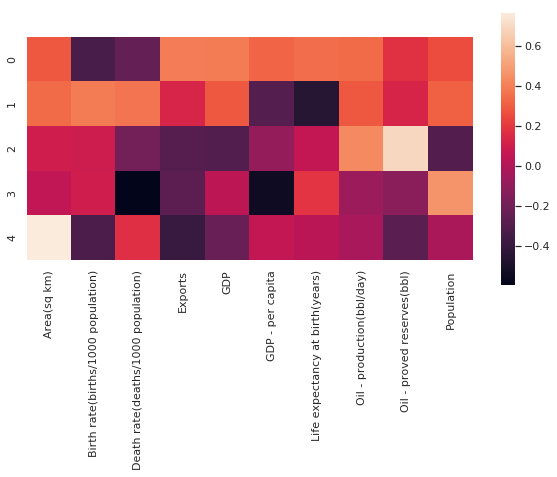

In [15]:
# For display reasons, we don't show all components if more than 50 (same for input variables)
n_components_to_show = min(50, sklearn_pca_final.n_components_)
n_input_features = sklearn_pca_final.components_.shape[1]

decomp_df = pd.DataFrame(sklearn_pca_final.components_[0:n_components_to_show],
                            columns=df.columns)
if decomp_df.shape[1] > 50:
    decomp_df = decomp_df[decomp_df.columns[0:50]]

fig = plt.figure(figsize=(n_input_features, n_components_to_show))
sns.set(font_scale=1)
sns.heatmap(decomp_df, square=True)
sns.set(font_scale=1)
insights.save_figure("Decomposition-heatmap1")

### Visualizing projected vectors

The final visualization that we can build is the visualization of both the original dataset and the transformed dataset,
in the original feature space.

We are going to select two features of the original dataset, and show on a XY graph:

* A scatterplot of the original dataset
* A scatterplot of the reduced dataset (after losing the unexplained varaince)
* The projection of the first two eigenvectors on the two selected features.

In [16]:
if len(numerical_columns) >= 2:
    feat1 = numerical_columns[0]
    feat2 = numerical_columns[1]
else:
    raise ValueError("Failed to automatically select proper variables to plot, please select manually")

print ("Will plot on these two features: '%s' and '%s'" % (feat1, feat2))

Will plot on these two features: 'Area(sq km)' and 'Birth rate(births/1000 population)'


In [17]:
# Uncomment this to take control on the two variables
# feat1 = "my_feat1"
# feat2 = "my_feat2"

In [18]:
idx_feat_1 = list(df.columns).index(feat1)
idx_feat_2 = list(df.columns).index(feat2)

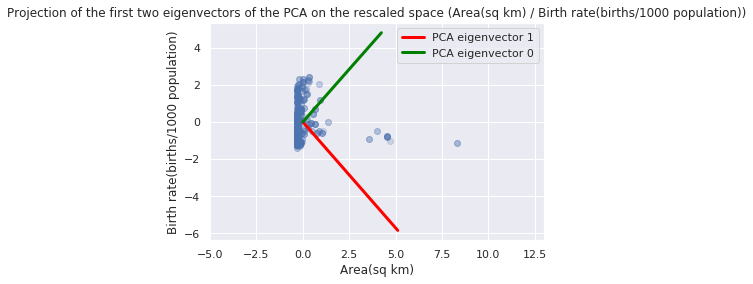

In [19]:
samp=1000
X_std_samp = np.random.choice(X_std.shape[0], samp)
plt.plot(X_std[X_std_samp, idx_feat_1], X_std[X_std_samp , idx_feat_2], 'o', alpha=0.1)
colors = ["green", "red"]
i = 0
for length, vector in list(zip(sklearn_pca_final.explained_variance_ratio_, sklearn_pca_final.components_))[0:2]:
    i = i+1
    i = i % len(colors)
    v = vector * 50 * length
    plt.plot([0, v[idx_feat_1]], [0, v[idx_feat_2]], '-k', lw=3, color=colors[i], label='PCA eigenvector ' + str(i))
plt.xlabel(feat1)
plt.ylabel(feat2)
plt.title('Projection of the first two eigenvectors of the PCA on the rescaled space (' + feat1 + ' / ' + feat2 + ')')
plt.legend(loc='upper right')
plt.axis("equal")
insights.save_figure("Projection-of-the-first-two-eigenvectors-of-the-PCA1")

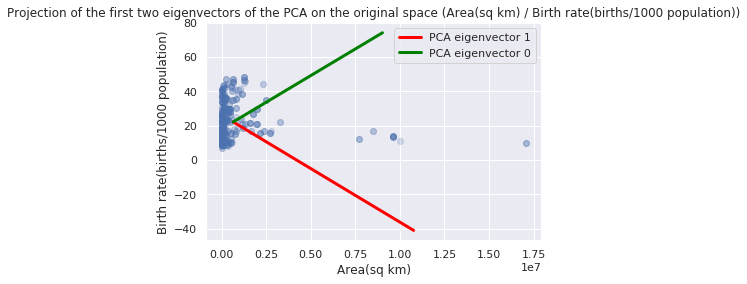

In [20]:
plt.plot(X[X_std_samp, idx_feat_1], X[X_std_samp , idx_feat_2], 'o', alpha=0.1)
colors = ["green", "red"]
i = 0
for length, vector in list(zip(sklearn_pca_final.explained_variance_ratio_, sklearn_pca_final.components_))[0:2]:
    i = i+1
    i = i % len(colors)
    #print vector
    v = ss.inverse_transform(vector * length * 50)
    #print v
    plt.plot([ss.mean_[idx_feat_1], v[idx_feat_1]], [ss.mean_[idx_feat_2], v[idx_feat_2]], '-k', lw=3, color=colors[i], label='PCA eigenvector ' + str(i))
plt.xlabel(feat1)
plt.ylabel(feat2)
plt.title('Projection of the first two eigenvectors of the PCA on the original space (' + feat1 + ' / ' + feat2 + ')')
plt.legend(loc='upper right')

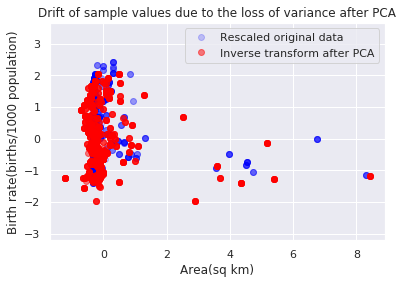

In [21]:
samp=1000
X_std_samp = np.random.choice(X_std.shape[0], samp)
X_new = sklearn_pca_final.inverse_transform(Y_sklearn_final)
plt.plot(X_std[X_std_samp, idx_feat_1], X_std[X_std_samp, idx_feat_2], 'o', alpha=0.2, color="blue", label="Rescaled original data")
plt.plot(X_new[X_std_samp, idx_feat_1], X_new[X_std_samp, idx_feat_2], 'ob', alpha=0.5, color="red", label="Inverse transform after PCA")
plt.xlabel(feat1)
plt.ylabel(feat2)
plt.title('Drift of sample values due to the loss of variance after PCA')
plt.legend(loc='upper right')
plt.axis("equal")
insights.save_figure("Drift-of-sample-values-due-to-the-loss-of-variance-after-PCA1")

## Applying the projection <a id="apply" />

Finally, we probably want to actually apply the PCA on the original data, which gives us the projected dataset

In [22]:
df_PCA = pd.DataFrame(Y_sklearn_final, columns=[("PCA_component_" + str(comp)) for comp in range(sklearn_pca_final.n_components)])

# Inserts back the date columns in the dataFrame with PCA applied
for date_col_idx in range(len(date_columns)):
    col = date_columns[date_col_idx]
    df_PCA.insert(date_col_idx , col, df_orig[col])

In [23]:
# Uncomment to display the head of the transformed matrix
#df_PCA.head()

In [24]:
# Recipe outputs
#fact_book_tsne = dataiku.Dataset("fact_book_tsne")
#fact_book_tsne.write_with_schema(pandas_dataframe)